# Data Loading

In [1]:
path1 = "Dataset/gauravduttakiit/banknote/versions/1"

print("Path to dataset files:", path1)


TRAIN_PATH = path1 + "/train.csv"
TEST_PATH = path1 + "/test.csv"

Path to dataset files: Dataset/gauravduttakiit/banknote/versions/1


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [3]:
df = pd.read_csv(TRAIN_PATH)

In [4]:
df.head()

,VWTI,SWTI,CWTI,EI,Class
0,2.2634,-4.4862,3.6558,-0.612510,0
1,3.2718,1.7837,2.1161,0.613340,0
2,-3.9411,-12.8792,13.0597,-3.312500,1
3,0.5195,-3.2633,3.0895,-0.984900,0
4,2.5698,-4.4076,5.9856,0.078002,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1096 entries, 0 to 1095
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   VWTI    1096 non-null   float64
 1   SWTI    1096 non-null   float64
 2   CWTI    1096 non-null   float64
 3   EI      1096 non-null   float64
 4   Class   1096 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 42.9 KB


In [6]:
X = df.drop(columns=['Class'])
y = df['Class']

# Обучение модели

## Базовая модель

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [8]:
baseline_model = GradientBoostingClassifier(random_state=42)
baseline_model.fit(X_train, y_train)
y_pred_base = baseline_model.predict(X_valid)

In [9]:
acc = accuracy_score(y_valid, y_pred_base)
prec = precision_score(y_valid, y_pred_base)
rec = recall_score(y_valid, y_pred_base)

In [10]:
print("Accuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)

Accuracy: 0.9863636363636363
Precision: 0.9767441860465116
Recall: 0.9882352941176471


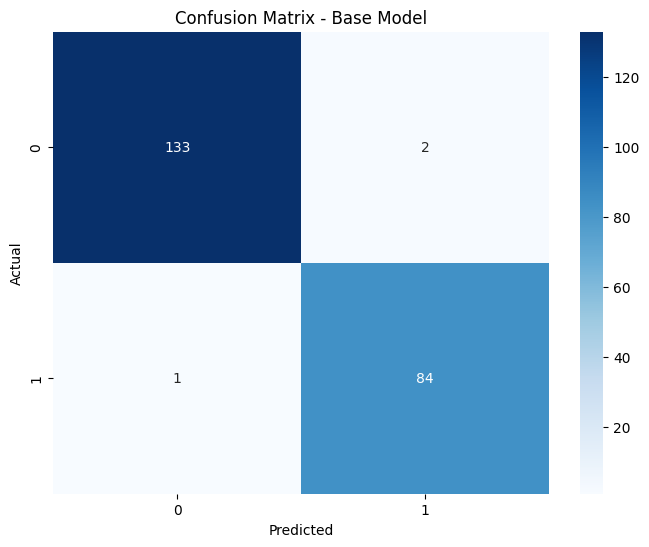

In [11]:
cm = confusion_matrix(y_valid, y_pred_base)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Base Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Улучшенная модель

Попробуем трансформировать имеющиеся фичи, они все численные

In [23]:
def make_engineered(df_in):
    df = df_in.copy()
    nums = df.select_dtypes(include=[np.number]).columns.tolist()

    for i in range(len(nums)):
        for j in range(i + 1, len(nums)):
            a = nums[i]
            b = nums[j]
            df[f"{a}_x_{b}"] = df[a] * df[b]
            df[f"{a}_minus_{b}"] = df[a] - df[b]
            df[f"{a}_abs_minus_{b}"] = np.abs(df[a] - df[b])

    for a in nums:
        df[f"{a}_sq"] = df[a] ** 2
        df[f"{a}_abs"] = np.abs(df[a])
        df[f"{a}_sign"] = np.sign(df[a])

    return df


X_train_fe = make_engineered(X_train)
X_valid_fe = make_engineered(X_valid)

print("Columns before:", X_train.shape[1])
print("Columns after:", X_train_fe.shape[1])

Columns before: 4
Columns after: 34


In [24]:
X_train_fe

,VWTI,SWTI,CWTI,EI,VWTI_x_SWTI,VWTI_minus_SWTI,VWTI_abs_minus_SWTI,VWTI_x_CWTI,VWTI_minus_CWTI,VWTI_abs_minus_CWTI,...,VWTI_sign,SWTI_sq,SWTI_abs,SWTI_sign,CWTI_sq,CWTI_abs,CWTI_sign,EI_sq,EI_abs,EI_sign
2,-3.94110,-12.8792,13.0597,-3.312500,50.758215,8.93810,8.93810,-51.469584,-17.00080,17.00080,...,-1.0,165.873793,12.8792,-1.0,170.555764,13.0597,1.0,10.972656,3.312500,-1.0
6,-2.29870,-5.2270,5.6300,0.917220,12.015305,2.92830,2.92830,-12.941681,-7.92870,7.92870,...,-1.0,27.321529,5.2270,-1.0,31.696900,5.6300,1.0,0.841293,0.917220,1.0
590,4.60140,5.6264,-2.1235,0.193090,25.889317,-1.02500,1.02500,-9.771073,6.72490,6.72490,...,1.0,31.656377,5.6264,1.0,4.509252,2.1235,-1.0,0.037284,0.193090,1.0
634,2.77440,6.8576,-1.0671,0.075416,19.025725,-4.08320,4.08320,-2.960562,3.84150,3.84150,...,1.0,47.026678,6.8576,1.0,1.138702,1.0671,-1.0,0.005688,0.075416,1.0
842,-1.60010,-9.5828,9.4044,0.081882,15.333438,7.98270,7.98270,-15.047980,-11.00450,11.00450,...,-1.0,91.830056,9.5828,-1.0,88.442739,9.4044,1.0,0.006705,0.081882,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
330,0.56953,7.6294,1.5754,-3.223300,4.345172,-7.05987,7.05987,0.897238,-1.00587,1.00587,...,1.0,58.207744,7.6294,1.0,2.481885,1.5754,1.0,10.389663,3.223300,-1.0
466,-2.77230,3.2777,-0.9351,-3.145700,-9.086768,-6.05000,6.05000,2.592378,-1.83720,1.83720,...,-1.0,10.743317,3.2777,1.0,0.874412,0.9351,-1.0,9.895428,3.145700,-1.0
121,5.02140,8.0764,-3.0515,-1.715500,40.554835,-3.05500,3.05500,-15.322802,8.07290,8.07290,...,1.0,65.228237,8.0764,1.0,9.311652,3.0515,-1.0,2.942940,1.715500,-1.0
1044,-1.13060,1.8458,-1.3575,-1.380600,-2.086861,-2.97640,2.97640,1.534790,0.22690,0.22690,...,-1.0,3.406978,1.8458,1.0,1.842806,1.3575,-1.0,1.906056,1.380600,-1.0


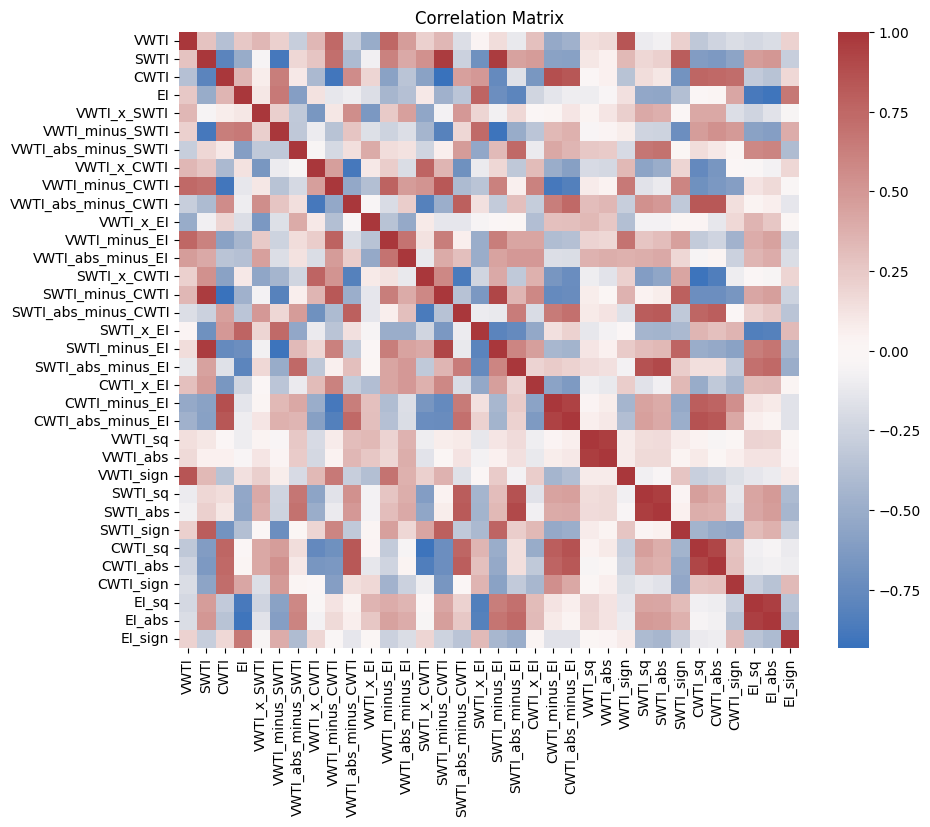

In [25]:
plt.figure(figsize=(10,8))
sns.heatmap(X_train_fe.corr(), cmap='vlag', center=0)
plt.title("Correlation Matrix")
plt.show()

In [26]:
numeric_cols_fe = X_train_fe.select_dtypes(include=[np.number]).columns.tolist()


Добавим признаки

In [27]:
top_features = ["VWTI_minus_EI", "SWTI_x_CWTI"]

X_train_imp = pd.concat(
    [X_train, X_train_fe[top_features]],
    axis=1
)

X_valid_imp = pd.concat(
    [X_valid, X_valid_fe[top_features]],
    axis=1
)

Подбор гиперпараметров 

In [28]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    'min_samples_split': [2, 5, 10]
}

gb = GradientBoostingClassifier(random_state=42)
grid_search = GridSearchCV(estimator=gb, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')
grid_search.fit(X_train_imp, y_train)

print("Best parameters:", grid_search.best_params_)

Best parameters: {'learning_rate': 0.2, 'max_depth': 3, 'min_samples_split': 10, 'n_estimators': 200}


Обучение

In [29]:
improved_model = grid_search.best_estimator_
improved_model.fit(X_train_imp, y_train)
y_pred_imp = improved_model.predict(X_valid_imp)

Метрики

In [30]:
acc_imp = accuracy_score(y_valid, y_pred_imp)
prec_imp = precision_score(y_valid, y_pred_imp)
rec_imp = recall_score(y_valid, y_pred_imp)

In [31]:
print("Improved Accuracy:", acc_imp)
print("Improved Precision:", prec_imp)
print("Improved Recall:", rec_imp)

Improved Accuracy: 1.0
Improved Precision: 1.0
Improved Recall: 1.0


Confusion Matrix

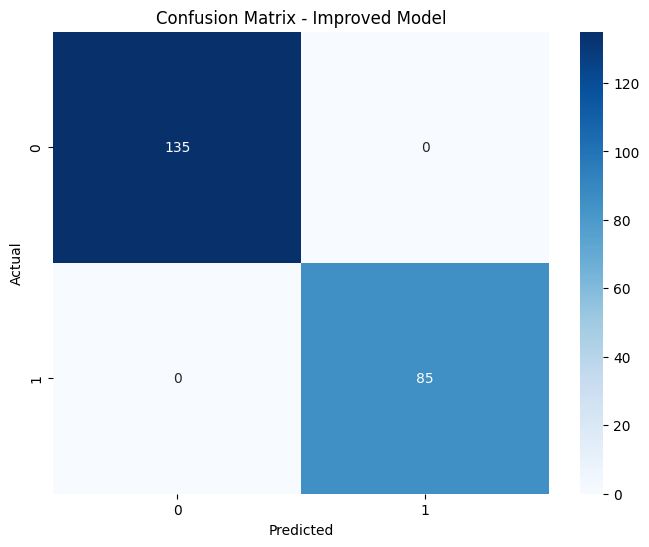

In [35]:
cm_imp = confusion_matrix(y_valid, y_pred_imp)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_imp, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Improved Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Реализованная модель

## Базовая модель

In [36]:
class DecisionStump:
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.polarity = 1

    def fit(self, X, y, sample_weight):
        n_samples, n_features = X.shape
        min_error = float("inf")

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])

            for threshold in thresholds:
                for polarity in [1, -1]:
                    predictions = np.ones(n_samples)
                    predictions[polarity * X[:, feature] < polarity * threshold] = 0

                    error = np.sum(sample_weight[predictions != y])

                    if error < min_error:
                        self.feature_index = feature
                        self.threshold = threshold
                        self.polarity = polarity
                        min_error = error

    def predict(self, X):
        n_samples = X.shape[0]
        predictions = np.ones(n_samples)
        idx = self.polarity * X[:, self.feature_index] < self.polarity * self.threshold
        predictions[idx] = 0
        return predictions


In [37]:
class GradientBoostingClassifierScratch:
    def __init__(self, n_estimators=20, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.models = []
        self.model_weights = []

    def fit(self, X, y):
        n_samples = X.shape[0]
        weights = np.ones(n_samples) / n_samples

        for _ in range(self.n_estimators):
            stump = DecisionStump()
            stump.fit(X, y, weights)
            preds = stump.predict(X)

            error = np.sum(weights[preds != y])
            error = max(error, 1e-10)

            alpha = self.learning_rate * 0.5 * np.log((1 - error) / error)

            weights *= np.exp(-alpha * ((y * 2 - 1) * (preds * 2 - 1)))
            weights /= np.sum(weights)

            self.models.append(stump)
            self.model_weights.append(alpha)

    def predict(self, X):
        model_preds = np.zeros(X.shape[0])

        for model, alpha in zip(self.models, self.model_weights):
            pred = model.predict(X)
            model_preds += alpha * (pred * 2 - 1)

        return (model_preds > 0).astype(int)


Обучение и предсказание

In [38]:
X_train_np = X_train.values
X_valid_np = X_valid.values

y_train_np = y_train.values
y_valid_np = y_valid.values

In [39]:
gb_imp = GradientBoostingClassifierScratch()

gb_imp.fit(X_train_np, y_train_np)
y_pred_imp = gb_imp.predict(X_valid_np)

In [40]:
print("Accuracy:", accuracy_score(y_valid_np, y_pred_base))
print("Precision:", precision_score(y_valid_np, y_pred_base))
print("Recall:", recall_score(y_valid_np, y_pred_base))

Accuracy: 0.9863636363636363
Precision: 0.9767441860465116
Recall: 0.9882352941176471


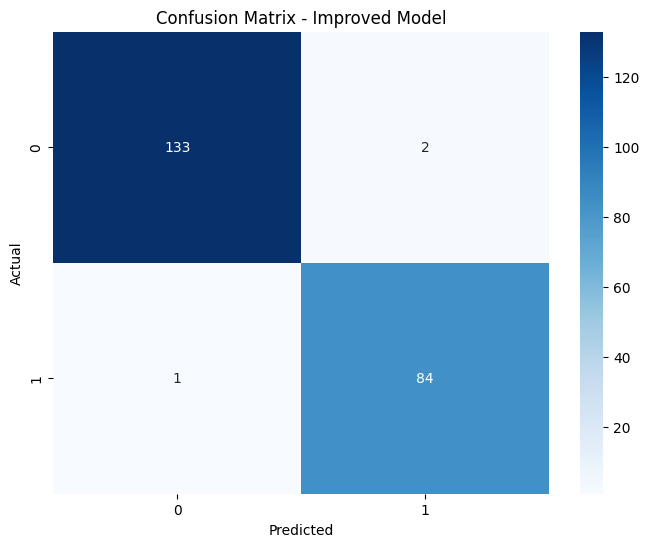

In [41]:
cm_base = confusion_matrix(y_valid, y_pred_base)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Improved Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Улучшенная модель

Добавим пару признаков

In [42]:
top_features = ["VWTI_minus_EI", "SWTI_x_CWTI"]

X_train_imp = pd.concat(
    [X_train, X_train_fe[top_features]],
    axis=1
)

X_valid_imp = pd.concat(
    [X_valid, X_valid_fe[top_features]],
    axis=1
)

In [43]:
X_train_imp_np = X_train_imp.values
X_valid_imp_np = X_valid_imp.values

Обучение и предикт

In [44]:
gb_imp = GradientBoostingClassifierScratch(
    n_estimators=200,
    learning_rate=0.2
)

gb_imp.fit(X_train_imp_np, y_train_np)
y_pred_imp = gb_imp.predict(X_valid_imp_np)

In [45]:
print("Accuracy:", accuracy_score(y_valid_np, y_pred_imp))
print("Precision:", precision_score(y_valid_np, y_pred_imp))
print("Recall:", recall_score(y_valid_np, y_pred_imp))

Accuracy: 0.9863636363636363
Precision: 0.9659090909090909
Recall: 1.0


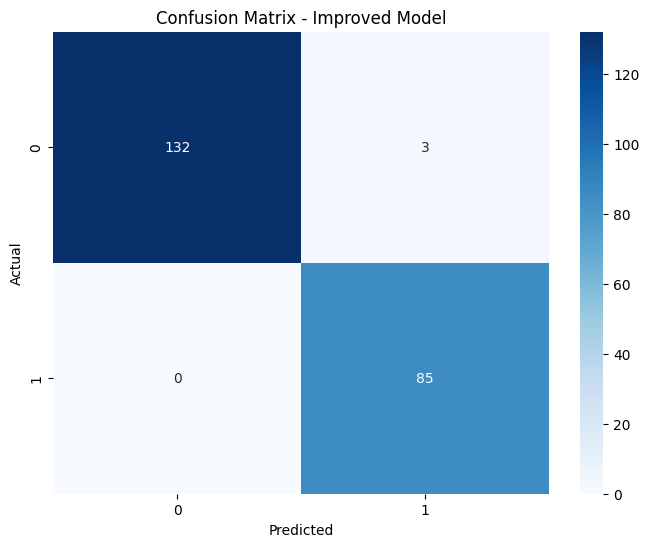

In [46]:
cm_imp = confusion_matrix(y_valid, y_pred_imp)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_imp, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix - Improved Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Достигли 1.0 метрики Recall

# Регрессия Data Loading

In [115]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [48]:
DATA_PATH = "Dataset/Water/water_consumption.csv"

In [51]:
df = pd.read_csv(DATA_PATH)

In [52]:
df.head()

,Country,Year,Total Water Consumption (Billion Cubic Meters),Per Capita Water Use (Liters per Day),Agricultural Water Use (%),Industrial Water Use (%),Household Water Use (%),Rainfall Impact (Annual Precipitation in mm),Groundwater Depletion Rate (%),Water Scarcity Level
0,Argentina,2000,481.490000,235.431429,48.550000,20.844286,30.100000,1288.698571,3.255714,Moderate
1,Argentina,2001,455.063000,299.551000,48.465000,26.943000,22.550000,1371.729000,3.120000,Moderate
2,Argentina,2002,482.749231,340.124615,50.375385,29.042308,23.349231,1590.305385,2.733846,Moderate
3,Argentina,2003,452.660000,326.756667,49.086667,30.476000,24.440000,1816.012667,2.708000,Moderate
4,Argentina,2004,634.566000,230.346000,38.670000,36.670000,23.924000,815.998000,1.902000,Moderate


In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   country                500 non-null    object 
 1   year                   500 non-null    int64  
 2   total_consumption      500 non-null    float64
 3   per_capita_use         500 non-null    float64
 4   agricultural_use       500 non-null    float64
 5   industrial_use         500 non-null    float64
 6   household_use          500 non-null    float64
 7   rainfall               500 non-null    float64
 8   groundwater_depletion  500 non-null    float64
 9   scarcity_level         500 non-null    object 
dtypes: float64(7), int64(1), object(2)
memory usage: 39.2+ KB


In [54]:
df = df.rename(columns={
"Country": "country",
"Year": "year",
"Total Water Consumption (Billion Cubic Meters)": "total_consumption",
"Per Capita Water Use (Liters per Day)": "per_capita_use",
"Agricultural Water Use (%)": "agricultural_use",
"Industrial Water Use (%)": "industrial_use",
"Household Water Use (%)": "household_use",
"Rainfall Impact (Annual Precipitation in mm)": "rainfall",
"Groundwater Depletion Rate (%)": "groundwater_depletion",
"Water Scarcity Level": "scarcity_level"
})

In [63]:
df.head()

,country,year,total_consumption,per_capita_use,agricultural_use,industrial_use,household_use,rainfall,groundwater_depletion,scarcity_level
0,Argentina,2000,481.490000,235.431429,48.550000,20.844286,30.100000,1288.698571,3.255714,Moderate
1,Argentina,2001,455.063000,299.551000,48.465000,26.943000,22.550000,1371.729000,3.120000,Moderate
2,Argentina,2002,482.749231,340.124615,50.375385,29.042308,23.349231,1590.305385,2.733846,Moderate
3,Argentina,2003,452.660000,326.756667,49.086667,30.476000,24.440000,1816.012667,2.708000,Moderate
4,Argentina,2004,634.566000,230.346000,38.670000,36.670000,23.924000,815.998000,1.902000,Moderate


In [55]:
X = df.drop(columns=["total_consumption"])
y = df["total_consumption"]

Категориальные признаки превратим в числовые

In [70]:
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

In [71]:
X = pd.get_dummies(X, columns=cat_cols, drop_first=True)

In [72]:
X

,year,per_capita_use,agricultural_use,industrial_use,household_use,rainfall,groundwater_depletion,country_Australia,country_Brazil,country_Canada,...,country_Russia,country_Saudi Arabia,country_South Africa,country_South Korea,country_Spain,country_Turkey,country_UK,country_USA,scarcity_level_Low,scarcity_level_Moderate
0,2000,235.431429,48.550000,20.844286,30.100000,1288.698571,3.255714,False,False,False,...,False,False,False,False,False,False,False,False,False,True
1,2001,299.551000,48.465000,26.943000,22.550000,1371.729000,3.120000,False,False,False,...,False,False,False,False,False,False,False,False,False,True
2,2002,340.124615,50.375385,29.042308,23.349231,1590.305385,2.733846,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,2003,326.756667,49.086667,30.476000,24.440000,1816.012667,2.708000,False,False,False,...,False,False,False,False,False,False,False,False,False,True
4,2004,230.346000,38.670000,36.670000,23.924000,815.998000,1.902000,False,False,False,...,False,False,False,False,False,False,False,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2020,292.970000,47.448000,25.266000,27.538000,1510.662000,2.431000,False,False,False,...,False,False,False,False,False,False,False,True,False,True
496,2021,275.978000,46.195000,32.223000,26.720000,754.615000,2.628000,False,False,False,...,False,False,False,False,False,False,False,True,False,True
497,2022,292.039000,54.810000,30.918000,22.638000,2119.898000,2.871000,False,False,False,...,False,False,False,False,False,False,False,True,False,True
498,2023,261.197500,62.945000,25.207500,21.632500,1439.155000,1.597500,False,False,False,...,False,False,False,False,False,False,False,True,False,True


In [73]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [74]:
X_train_np = X_train.values
X_valid_np = X_valid.values
y_train_np = y_train.values
y_valid_np = y_valid.values

# Обучение модели

## Базовая версия

In [75]:
gb_base = GradientBoostingRegressor()

обучение

In [76]:
gb_base.fit(X_train_np, y_train_np)
y_pred_base = gb_base.predict(X_valid_np)

метрики

In [77]:
mae = mean_absolute_error(y_valid_np, y_pred_base)
rmse = np.sqrt(mean_squared_error(y_valid_np, y_pred_base))

In [78]:
print("MAE:", mae)
print("RMSE:", rmse)

MAE: 76.5999679785627
RMSE: 99.04154555657543


## Улучшенная модель

Проведем анализ фичей, попробуем выявить скрытую закономерность

In [96]:
def make_engineered(df_in):
    df = df_in.copy()
    nums = df.select_dtypes(include=[np.number]).columns.tolist()

    for i in range(len(nums)):
        for j in range(i + 1, len(nums)):
            a = nums[i]; b = nums[j]
            df[f"{a}_x_{b}"] = df[a] * df[b]
            df[f"{a}_minus_{b}"] = df[a] - df[b]
            df[f"{a}_abs_minus_{b}"] = np.abs(df[a] - df[b])

    for a in nums:
        df[f"{a}_sq"] = df[a] ** 2
        df[f"{a}_abs"] = np.abs(df[a])
        df[f"{a}_sign"] = np.sign(df[a])

    return df

X_train_fe = make_engineered(X_train)
X_valid_fe = make_engineered(X_valid)

print("Before:", X_train.shape[1], "After:", X_train_fe.shape[1])


Before: 28 After: 112


In [109]:
num_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

engineered_extra = [c for c in X_train_fe.columns if c not in X_train.columns]

X_train_fe_numeric = X_train_fe[num_cols + engineered_extra]
X_valid_fe_numeric = X_valid_fe[num_cols + engineered_extra]

Корреляция

In [113]:
# Корреляция только по числовым фичам
corr = pd.concat([X_train_fe_numeric, y_train], axis=1).corr()["total_consumption"].abs()

# engineered-фичи = всё, что НЕ относится к оригинальным числам
engineered_cols_only = [c for c in X_train_fe_numeric.columns if c not in num_cols]

# сортировка engineered по корреляции
sorted_engineered = corr[engineered_cols_only].sort_values(ascending=False)

top3 = sorted_engineered.index[:3].tolist()

top3


['industrial_use_x_groundwater_depletion',
 'year_minus_industrial_use',
 'year_abs_minus_industrial_use']

In [123]:
X_train_imp = pd.concat([X_train, X_train_fe_numeric[top3]], axis=1)
X_valid_imp = pd.concat([X_valid, X_valid_fe_numeric[top3]], axis=1)

Подроб гиперпараметров

In [124]:
param_grid = {
    "n_estimators": [80, 120, 200],
    "learning_rate": [0.05, 0.07, 0.1],
    "max_depth": [2, 3, 4],
    "min_samples_split": [2, 5, 10]
}

In [125]:
gbr = GradientBoostingRegressor(random_state=42)

gs = GridSearchCV(
    estimator=gbr,
    param_grid=param_grid,
    scoring="neg_mean_absolute_error",
    cv=5,
    n_jobs=-1
)

Обучение

In [126]:
gs.fit(X_train_imp, y_train)

GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.07, 0.1],
                         'max_depth': [2, 3, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [80, 120, 200]},
             scoring='neg_mean_absolute_error')

Предсказание

In [127]:
gb_best = gs.best_estimator_
y_pred_best = gb_best.predict(X_valid_imp)

Метрики

In [128]:
mae_best = mean_absolute_error(y_valid, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_valid, y_pred_best))

In [122]:
print("MAE:", mae_best)
print("RMSE:", rmse_best)

MAE: 75.10514057191392
RMSE: 98.3485918250259


## Реализованная модель

In [129]:
class DecisionStumpRegressor:
    def __init__(self):
        self.feature_index = None
        self.threshold = None
        self.left_value = None
        self.right_value = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        best_error = float("inf")

        for feature in range(n_features):
            thresholds = np.unique(X[:, feature])
            for thr in thresholds:
                left_mask = X[:, feature] <= thr
                right_mask = ~left_mask

                if left_mask.sum() == 0 or right_mask.sum() == 0:
                    continue

                left_mean = y[left_mask].mean()
                right_mean = y[right_mask].mean()

                pred = np.where(left_mask, left_mean, right_mean)
                mse = np.mean((y - pred) ** 2)

                if mse < best_error:
                    best_error = mse
                    self.feature_index = feature
                    self.threshold = thr
                    self.left_value = left_mean
                    self.right_value = right_mean

    def predict(self, X):
        mask = X[:, self.feature_index] <= self.threshold
        return np.where(mask, self.left_value, self.right_value)


In [130]:
class GradientBoostingRegressorScratch:
    def __init__(self, n_estimators=50, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.learning_rate = learning_rate
        self.trees = []

    def fit(self, X, y):
        pred = np.zeros_like(y, dtype=float)

        for _ in range(self.n_estimators):
            residuals = y - pred
            stump = DecisionStumpRegressor()
            stump.fit(X, residuals)
            self.trees.append(stump)
            pred += self.learning_rate * stump.predict(X)

    def predict(self, X):
        pred = np.zeros(X.shape[0], dtype=float)
        for stump in self.trees:
            pred += self.learning_rate * stump.predict(X)
        return pred


### Базовая версия

In [132]:
X_train_np = X_train.values
X_valid_np = X_valid.values
y_train_np = y_train.values
y_valid_np = y_valid.values

In [133]:
gb_scratch = GradientBoostingRegressorScratch()

In [134]:
gb_scratch.fit(X_train_np, y_train_np)
y_pred_scratch = gb_scratch.predict(X_valid_np)


In [135]:
print("MAE:", mean_absolute_error(y_valid_np, y_pred_scratch))
print("RMSE:", np.sqrt(mean_squared_error(y_valid_np, y_pred_scratch)))

MAE: 76.7357943284704
RMSE: 99.45188058227859


### Улучшенная версия

In [137]:
X_train_imp_np = X_train_imp.values
X_valid_imp_np = X_valid_imp.values

In [138]:
gb_scratch_imp = GradientBoostingRegressorScratch(
    n_estimators=80,
    learning_rate=0.05)

In [139]:
gb_scratch_imp.fit(X_train_imp_np, y_train_np)
y_pred_scratch_imp = gb_scratch_imp.predict(X_valid_imp_np)

In [140]:
print("MAE:", mean_absolute_error(y_valid_np, y_pred_scratch_imp))
print("RMSE:", np.sqrt(mean_squared_error(y_valid_np, y_pred_scratch_imp)))

MAE: 76.80080724593287
RMSE: 98.84966275412333


# Результаты

## Классификация

In [70]:
results_dfc = pd.DataFrame({
    'Модель': ['Базовая модель', 'Улучшенная модель', 
               'Реализованная базовая модель', 'Улучшенная реализованная модель'],
    'Accuracy': [0.9863636363636363, 1.0, 
                 0.9863636363636363, 0.9863636363636363],
    'Precision': [0.9767441860465116, 1.0, 
                  0.9767441860465116, 0.9659090909090909],
    'Recall': [0.9882352941176471, 1.0, 
               0.9882352941176471, 1.0]
})

In [71]:
results_dfc

,Модель,Accuracy,Precision,Recall
0,Базовая модель,0.986364,0.976744,0.988235
1,Улучшенная модель,1.000000,1.000000,1.000000
2,Реализованная базовая модель,0.986364,0.976744,0.988235
3,Улучшенная реализованная модель,0.986364,0.965909,1.000000


## Регрессия

In [141]:
results_dfr = pd.DataFrame({
    'Модель': ['Базовая модель', 'Улучшенная модель', 
               'Реализованная базовая модель', 'Улучшенная реализованная модель'],
    'MAE': [76.5999679785627, 75.10514057191392, 
            76.7357943284704, 76.80080724593287],
    'RMSE': [99.04154555657543, 98.3485918250259, 
             99.45188058227859, 98.84966275412333]
})

In [143]:
results_dfr

,Модель,MAE,RMSE
0,Базовая модель,76.599968,99.041546
1,Улучшенная модель,75.105141,98.348592
2,Реализованная базовая модель,76.735794,99.451881
3,Улучшенная реализованная модель,76.800807,98.849663


# Общие результаты всех работ

## Классификация

In [144]:
knn_data = pd.DataFrame({
    'Model': ['KNN'] * 2,
    'Version': ['Базовая модель', 'Реализованная модель'],
    'Accuracy': [1.0000, 1.0000],
    'Precision': [1.0000, 1.0000],
    'Recall': [1.0000, 1.0000]
})

lr_data = pd.DataFrame({
    'Model': ['LogisticRegression'] * 4,
    'Version': ['Базовая модель', 'Улучшенная модель', 
                'Реализованная базовая модель', 'Улучшенная реализованная модель'],
    'Accuracy': [0.981818, 0.990909, 0.972727, 0.990909],
    'Precision': [0.965517, 0.989796, 0.964706, 0.989796],
    'Recall': [0.988235, 0.989796, 0.964706, 0.989796]
})

dt_data = pd.DataFrame({
    'Model': ['DecisionTreeClassifier'] * 4,
    'Version': ['Базовая модель', 'Улучшенная модель', 
                'Реализованная базовая модель', 'Улучшенная реализованная модель'],
    'Accuracy': [0.981818, 0.987879, 0.993939, 0.993939],
    'Precision': [0.968254, 0.973333, 1.000000, 0.986486],
    'Recall': [0.983871, 1.000000, 0.983871, 1.000000]
})

rf_data = pd.DataFrame({
    'Model': ['RandomForestClassifier'] * 4,
    'Version': ['Базовая модель', 'Улучшенная модель', 
                'Реализованная базовая модель', 'Улучшенная реализованная модель'],
    'Accuracy': [0.990909, 0.996960, 0.978723, 0.984802],
    'Precision': [0.977011, 0.993197, 0.972789, 0.979592],
    'Recall': [1.000000, 1.000000, 0.979452, 0.986301]
})

gb_data = pd.DataFrame({
    'Model': ['GradientBoostingClassifier'] * 4,
    'Version': ['Базовая модель', 'Улучшенная модель', 
                'Реализованная базовая модель', 'Улучшенная реализованная модель'],
    'Accuracy': [0.986364, 1.000000, 0.986364, 0.986364],
    'Precision': [0.976744, 1.000000, 0.976744, 0.965909],
    'Recall': [0.988235, 1.000000, 0.988235, 1.000000]
})

In [145]:
all_models_df = pd.concat([knn_data, lr_data, dt_data, rf_data, gb_data], ignore_index=True)

In [146]:
all_models_df

,Model,Version,Accuracy,Precision,Recall
0,KNN,Базовая модель,1.000000,1.000000,1.000000
1,KNN,Реализованная модель,1.000000,1.000000,1.000000
2,LogisticRegression,Базовая модель,0.981818,0.965517,0.988235
3,LogisticRegression,Улучшенная модель,0.990909,0.989796,0.989796
4,LogisticRegression,Реализованная базовая модель,0.972727,0.964706,0.964706
5,LogisticRegression,Улучшенная реализованная модель,0.990909,0.989796,0.989796
6,DecisionTreeClassifier,Базовая модель,0.981818,0.968254,0.983871
7,DecisionTreeClassifier,Улучшенная модель,0.987879,0.973333,1.000000
8,DecisionTreeClassifier,Реализованная базовая модель,0.993939,1.000000,0.983871
9,DecisionTreeClassifier,Улучшенная реализованная модель,0.993939,0.986486,1.000000


### Выводы

По результатам видно, что числовые фичи имеют четкое разделение на классы

Модель KNN показала максимум по всем метрикам, абсолютный лидер

## Регрессия

In [148]:
knn_data = pd.DataFrame({
    'Model': ['KNNRegressor'] * 2,
    'Version': ['Базовая модель', 'Улучшенная модель'],
    'MAE': [102.446627, 79.884922],
    'RMSE': [117.558044, 93.854929]
})

lr_data = pd.DataFrame({
    'Model': ['LinearRegression'] * 4,
    'Version': ['Базовая модель', 'Улучшенная модель', 
                'Реализованная базовая модель', 'Улучшенная реализованная модель'],
    'MAE': [81.131702, 74.986074, 75.733450, 72.919403],
    'RMSE': [104.637535, 99.449672, 97.872581, 97.385479]
})

rf_data = pd.DataFrame({
    'Model': ['RandomForestRegressor'] * 4,
    'Version': ['Базовая модель', 'Улучшенная модель', 
                'Реализованная базовая модель', 'Улучшенная реализованная модель'],
    'MAE': [79.897016, 76.520269, 79.539604, 77.777252],
    'RMSE': [107.203015, 101.541905, 107.020667, 102.398497]
})

gb_data = pd.DataFrame({
    'Model': ['GradientBoostingRegressor'] * 4,
    'Version': ['Базовая модель', 'Улучшенная модель', 
                'Реализованная базовая модель', 'Улучшенная реализованная модель'],
    'MAE': [76.599968, 75.105141, 76.735794, 76.800807],
    'RMSE': [99.041546, 98.348592, 99.451881, 98.849663]
})



In [149]:
all_models_df = pd.concat([knn_data, lr_data, rf_data, gb_data], ignore_index=True)

In [150]:
all_models_df

,Model,Version,MAE,RMSE
0,KNNRegressor,Базовая модель,102.446627,117.558044
1,KNNRegressor,Улучшенная модель,79.884922,93.854929
2,LinearRegression,Базовая модель,81.131702,104.637535
3,LinearRegression,Улучшенная модель,74.986074,99.449672
4,LinearRegression,Реализованная базовая модель,75.733450,97.872581
5,LinearRegression,Улучшенная реализованная модель,72.919403,97.385479
6,RandomForestRegressor,Базовая модель,79.897016,107.203015
7,RandomForestRegressor,Улучшенная модель,76.520269,101.541905
8,RandomForestRegressor,Реализованная базовая модель,79.539604,107.020667
9,RandomForestRegressor,Улучшенная реализованная модель,77.777252,102.398497


### Выводы

Даже с улучшением каждой модели результаты всеравно не сильно улучшались, возможно дело в неправильных гипотезах или же в отсутствии правильных

В данных было много шума, скорее всего поэтому MAE не опустилась ниже 72. Предсказание для каждой страны отдельном было бы лучшним решением. 